## Content-Based Image Retrieval

- Aurora Cerabolini
- Veronica Morelli

## Import packages

In [ ]:
from google.colab import drive
import zipfile
import time 
from shutil import copyfile
import cv2 as cv
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image as kimage
from tensorflow import keras 
from sklearn.neighbors import KDTree
import keras
from keras import layers

## Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
copyfile('gdrive/MyDrive/DSIM Project/CBIR/food_images.zip', 'food_images.zip')

'food_images.zip'

In [ ]:
from time import time

In [ ]:
t0 = time()
zip = zipfile.ZipFile('food_images.zip') 
zip.extractall()
zip.close()
print("File transfer completed in %0.3f seconds" % (time() - t0))

File transfer completed in 74.511 seconds


## Data Creation

In [ ]:
import os

In [ ]:
path = os.listdir('/content/food_images/')
path.remove('.DS_Store') 
print(path)

['fish_and_chips', 'deviled_eggs', 'eggs_benedict', 'pork_chop', 'french_toast', 'club_sandwich', 'greek_salad', 'prime_rib', 'chocolate_cake', 'escargots', 'risotto', 'lobster_roll_sandwich', 'cheese_plate', 'beignets', 'bread_pudding', 'garlic_bread', 'hot_and_sour_soup', 'ceviche', 'onion_rings', 'baby_back_ribs', 'panna_cotta', 'grilled_cheese_sandwich', 'oysters', 'gyoza', 'fried_calamari', 'ramen', 'sashimi', 'falafel', 'strawberry_shortcake', 'hamburger', 'frozen_yogurt', 'filet_mignon', 'caprese_salad', 'clam_chowder', 'chicken_wings', 'ice_cream', 'pho', 'cheesecake', 'spring_rolls', 'seaweed_salad', 'bibimbap', 'chicken_curry', 'shrimp_and_grits', 'grilled_salmon', 'omelette', 'pizza', 'creme_brulee', 'macaroni_and_cheese', 'apple_pie', 'croque_madame', 'chocolate_mousse', 'bruschetta', 'baklava', 'cannoli', 'mussels', 'nachos', 'ravioli', 'peking_duck', 'carrot_cake', 'pad_thai', 'hot_dog', 'red_velvet_cake', 'french_fries', 'breakfast_burrito', 'steak', 'scallops', 'gnocchi

La funzione data_creation accede alla cartella principale food_images e alle sue sottocartelle ed è possibile specificare:
- quante immagini estrarre in totale
- quante sottocartelle considerare
- quante immagini di cibo considerare per ogni sottocartella

Specificando il feature_extractor, verranno estratte le features dalle immagini prese in considerazione

In [ ]:
# Dummy feature
def identity(img):
  return kimage.img_to_array(img).flatten()

def data_creation(dataset_path, img_per_food = 10000, food_to_consider = 10000, 
                  tot_img = 99999999, feature_extractor=identity):
    paths = []
    features = []

    for n_subf, subfold in enumerate(sorted(path)): 
      if n_subf > food_to_consider or len(features) > tot_img:
        break
      
      subpath = os.path.join(dataset_path, subfold)
      count = 0
      for im,img in enumerate(sorted(os.listdir(subpath))):
        if len(features) > tot_img or count >= img_per_food:
          break
        if img.endswith('.jpg'): 
            cur_path = os.path.join(subpath, img) 
            image = cv.imread(cur_path)
            image = cv.resize(image, (224, 224)) 
            cur_features = feature_extractor(image)
            features.append(cur_features)
            paths.append(cur_path) 
            count = count + 1    
    features = np.array(features)
    return features, paths

## MobileNetV2

In [ ]:
base_net = keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet", pooling="max")

9406464/9406464 [==============================] - 0s 0us/step


### Feature extraction with MobileNetV2

In [ ]:
def mobilenetv2_features(img):
  x = kimage.img_to_array(img)
  x = keras.applications.mobilenet_v2.preprocess_input(x) 
  x = np.expand_dims(x, axis = 0)
  features = base_net.predict(x)
  features = features.flatten()
  return features

Vengono create le features utilizzando la rete preaddestrata di MobileNetV2. Le features create sono state salvate per non doverle ricreare ad ogni avvio del notebook.

In [ ]:
#carico le feature che ho già creato
X_train_mn = np.load('gdrive/MyDrive/DSIM Project/CBIR/features_mobilenet.npy')
paths_mn = np.load('gdrive/MyDrive/DSIM Project/CBIR/paths_mobilenet.npy')

#food_path = '/content/food_images'
#X_train_mn, paths_mn = data_creation(food_path, img_per_food=100, 
#                                       feature_extractor=mobilenetv2_features)

#np.save('gdrive/MyDrive/DSIM Project/CBIR/features_mobilenet', X_train_mn)
#np.save('gdrive/MyDrive/DSIM Project/CBIR/paths_mobilenet', paths_mn)

In [ ]:
print("Numero di elementi:", len(paths_mn))
print("Dimensione delle features:", X_train_mn.shape)

Numero di elementi: 10100
Dimensione delle features: (10100, 1280)


## Retrieving similar image

Ricerco l'immagine più simile presente nel training set sfruttando la procedura di kdtree che è ottimizzata e permette di effettuare una ricerca efficiente.

L'algoritmo funziona in questo modo:

1. Divide lo spazio rispetto alla prima dimensione calcolando il mediano sull'asse orizzontale
2. Divide lo spazio rispetto alla seconda dimensione calcolando il mediano sull'asse verticale
3. Continua così per tutte le dimensioni e poi ricomincia dal primo punto.

Così si è creato un albero di ricerca che viene utilizzato per estrarre l'immagine più vicina in modo ottimizzato e senza verificare tutti i punti.

1. Rispetto alla prima dimensione si chiede se la prima coordinata è maggiore o inferiore ed elimina i restanti punti
2. Ripete il punto 1 per tutte le dimensioni.
3. Si arriva ad un solo punto (foglia dell'albero) e quindi è un candidato ad essere uno dei più simili.
4. Si percorre quindi a ritroso l'albero delle decisioni e si calcola la distanza della query rispetto al nodo corrente e si usano una serie di accorgimenti per non calcolarla rispetto a tutti i punti e tutte le dimensioni.

### Features MobileNetV2 + KDTree

In [ ]:
%%time
#calcolo l'albero basato sulle features di mobilenet
tree_mn = KDTree(X_train_mn)

CPU times: user 1.84 s, sys: 46.2 ms, total: 1.89 s
Wall time: 1.91 s


In [ ]:
#query image
img_query = cv.imread('gdrive/MyDrive/DSIM Project/CBIR/3569_Risotto.jpg')
img_query = cv.resize(img_query, (224, 224))
query_features = mobilenetv2_features(img_query)
query_features = np.expand_dims(query_features, axis = 0)
distance, idx = tree_mn.query(query_features, k=10) #distance is the squared euclidean distance

1/1 [==============================] - 0s 78ms/step


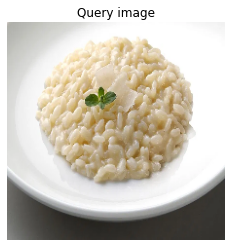

In [ ]:
plt.imshow(cv.cvtColor(img_query, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Query image")
plt.show()

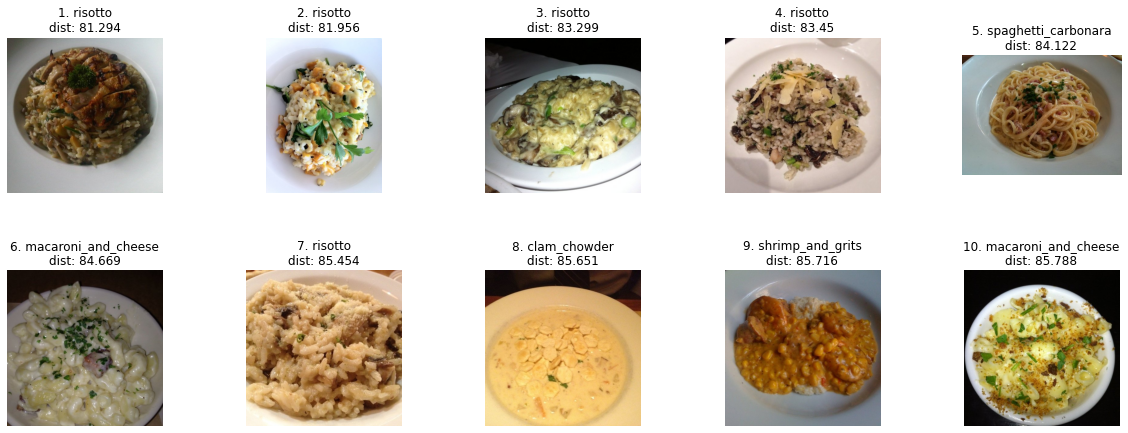

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(10):  
  img = cv.imread(paths_mn[idx[0][i]]) 
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

  ax = plt.subplot(5, 5, i + 1)
  plt.subplots_adjust(wspace=0.5, hspace = 0.5)
  plt.imshow(img)
  plt.axis("off")

  name = paths_mn[idx[0][i]].split('/')[-2]
  str_title = str(i+1) +". " + name + "\ndist: " + str(np.round(distance[0][i], 3))
  plt.title(str_title)

## Autoencoder

Un autoencoder è una rete neurale che si compone di due parti: encoder e decoder. La prima parte riduce la dimensionalità del dato in input mentre la seconda, partendo dalla rappresentazione ridotta creata dall’encoder, cerca di ricostruire il dato originale. Attraverso il training si ottiene che l’encoder impara a generare una rappresentazione compressa limitando al minimo la perdita di dati.

In [ ]:
input = layers.Input(shape=(224, 224, 3))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(16, (3, 3), activation="relu", padding="same")(x)
encoded = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(16, (3, 3), activation="relu", padding="same")(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(64, (3, 3), activation="relu", padding="same")(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer="adam", loss="mse") # o binary_crossentropy se normalizziamo i dati

autoencoder.summary()

# Encoder
encoder = keras.Model(input, encoded)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 32)      18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 56, 56, 16)        4624

In [ ]:
# Load photos for training the autoencoder
def load_train_data(max_images=5):
  train_images = []
  for n_subf, subfold in enumerate(sorted(path)): 
    subpath = os.path.join('/content/food_images/', subfold) 
    for im,img in enumerate(sorted(os.listdir(subpath))): 
      if img.endswith('.jpg') and im < max_images:
        cur_path = os.path.join(subpath, img)
        img = cv.imread(cur_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (224, 224))
        train_images.append(img)
  train_images = np.array(train_images)/255.0
  return train_images    

In [ ]:
# Load 5 photos per food
train_images = load_train_data(max_images=5)

In [ ]:
autoencoder.fit(x=train_images, y=train_images, epochs=30, batch_size=64)

Epoch 1/30
5/5 [==============================] - 123s 24s/step - loss: 0.0827
Epoch 2/30
5/5 [==============================] - 115s 22s/step - loss: 0.0753
Epoch 3/30
5/5 [==============================] - 112s 22s/step - loss: 0.0572
Epoch 4/30
5/5 [==============================] - 115s 23s/step - loss: 0.0375
Epoch 5/30
5/5 [==============================] - 122s 24s/step - loss: 0.0351
Epoch 6/30
5/5 [==============================] - 115s 22s/step - loss: 0.0268
Epoch 7/30
5/5 [==============================] - 121s 25s/step - loss: 0.0225
Epoch 8/30
5/5 [==============================] - 113s 22s/step - loss: 0.0191
Epoch 9/30
5/5 [==============================] - 117s 23s/step - loss: 0.0171
Epoch 10/30
5/5 [==============================] - 122s 24s/step - loss: 0.0159
Epoch 11/30
5/5 [==============================] - 116s 23s/step - loss: 0.0151
Epoch 12/30
5/5 [==============================] - 113s 23s/step - loss: 0.0144
Epoch 13/30
5/5 [==============================] 

In [ ]:
autoencoder.save('gdrive/MyDrive/DSIM Project/CBIR/autoencoder.h5')

In [ ]:
encoder.save('gdrive/MyDrive/DSIM Project/CBIR/encoder.h5')

### Test with image from training set

1/1 [==============================] - 0s 253ms/step


Text(0.5, 1.0, 'Encoded + Decoded')

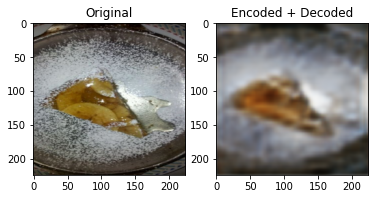

In [ ]:
pred = autoencoder.predict(np.expand_dims(train_images[0], axis=0))

# Plot images
plt.subplot(1, 2, 1); plt.imshow(train_images[0]); plt.title('Original')
plt.subplot(1, 2, 2); plt.imshow(pred[0]); plt.title('Encoded + Decoded')

### Test with image not used for training

1/1 [==============================] - 0s 181ms/step


Text(0.5, 1.0, 'Encoded + Decoded')

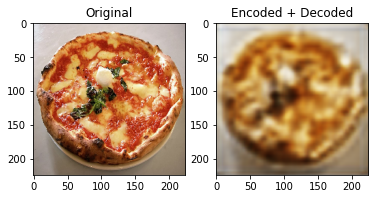

In [ ]:
# Load image
img = cv.imread('gdrive/MyDrive/DSIM Project/CBIR/pizza-margherita.jpg')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = cv.resize(img, (224, 224))
img = np.array(img)/255.0

# Encode and decode image
pred = autoencoder.predict(np.expand_dims(img, axis=0))

# Plot images
plt.subplot(1, 2, 1); plt.imshow(img); plt.title('Original')
plt.subplot(1, 2, 2); plt.imshow(pred[0]); plt.title('Encoded + Decoded')

### Feature extraction encoder layer in convolutional autoencoder

Le rappresentazioni delle immagini ottenute dall'encoder vengono utilizzate come feature

In [ ]:
encoder = keras.models.load_model('gdrive/MyDrive/DSIM Project/CBIR/encoder.h5')

In [ ]:
def encoder_features(img):
  x = kimage.img_to_array(img)
  x = np.array(x)/255.0
  x = np.expand_dims(x, axis = 0)
  features = encoder.predict(x)
  features = features.flatten()
  return features

In [ ]:
#carico le feature che ho già creato
X_train_en = np.load('gdrive/MyDrive/DSIM Project/CBIR/features_encoder.npy')
paths_en = np.load('gdrive/MyDrive/DSIM Project/CBIR/paths_encoder.npy')

#food_path = '/content/food_images'
#X_train_en, paths_en = data_creation(food_path, img_per_food=100,
#                                     feature_extractor=encoder_features)

#np.save('gdrive/MyDrive/DSIM Project/CBIR/features_encoder', X_train_en)
#np.save('gdrive/MyDrive/DSIM Project/CBIR/paths_encoder', paths_en)

In [ ]:
print("Numero di elementi:", len(paths_en))
print("Dimensione delle features:", X_train_en.shape)

Numero di elementi: 10100
Dimensione delle features: (10100, 12544)


## Retrieving similar image

### Features encoder + KDTree

In [ ]:
%%time
#calcolo l'albero basato sulle features dell'encoder
tree_en = KDTree(X_train_en)

CPU times: user 27.1 s, sys: 1.18 s, total: 28.2 s
Wall time: 34.5 s


In [ ]:
#query image
img_query = cv.imread('gdrive/MyDrive/DSIM Project/CBIR/3569_Risotto.jpg') 
img_query = cv.resize(img_query, (224, 224))
query_features = encoder_features(img_query)
query_features = np.expand_dims(query_features, axis = 0)
distance, idx = tree_en.query(query_features, k=10) #distance is the squared euclidean distance

1/1 [==============================] - 0s 46ms/step


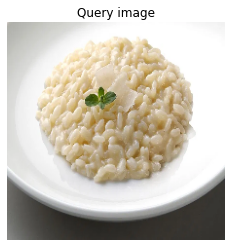

In [ ]:
plt.imshow(cv.cvtColor(img_query, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Query image")
plt.show()

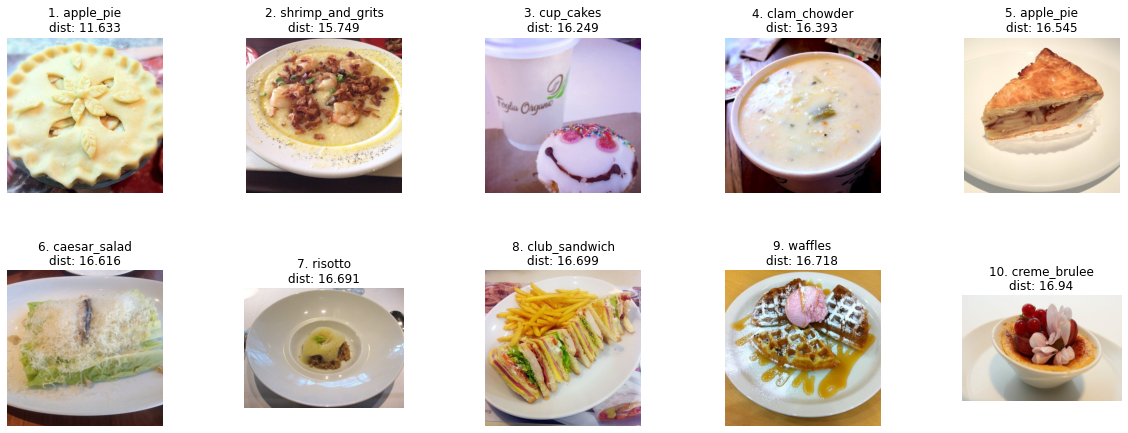

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(10):  
  img = cv.imread(paths_en[idx[0][i]]) 
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

  ax = plt.subplot(5, 5, i + 1)
  plt.subplots_adjust(wspace=0.5, hspace = 0.5)
  plt.imshow(img)
  plt.axis("off")

  name = paths_en[idx[0][i]].split('/')[-2]
  str_title = str(i+1) +". " + name + "\ndist: " + str(np.round(distance[0][i], 3))
  plt.title(str_title)